#Обучение классификатора на реальном датасете.

##Пояснение:
Требуется обучить классификатор определяющий тип велосипеда на небольшом датасете фотографий велосипедов из открытых источников. Допускается использовать пред-обученные модели из torchvision.models
По результатам работы составьте отчет.

##Задачи:

* Загрузите Датасет по ссылке: http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip Используйте встроенные классы из пакета torchvision.datasets либо создайте свой являющийся наследником базового класса Dataset из этого пакета.
* Проведите аугментацию данных как минимум 3-мя различными способами. Как минимум одни из них должен быть реализован самостоятельно.
* Используйте технологию Transfer learning: 
** измените выходной слой выбранной вами предобученной модели.
** Заморозьте часть весов.
* Обучить модель с использование GPU. Учитывайте особенности данных при выборе настройте Loss-функции
*Оцените результаты.
* Напишите отчет.



*Сохраняйте веса модели на GoogleDrive

In [4]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

--2022-01-10 13:30:51--  http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip
Resolving fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)... 212.24.105.216
Connecting to fmb.images.gan4x4.ru (fmb.images.gan4x4.ru)|212.24.105.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110280897 (105M) [application/zip]
Saving to: ‘bt_dataset3.zip’

bt_dataset3.zip     100%[===================>] 105.17M  1.17MB/s    in 99s     

2022-01-10 13:32:31 (1.07 MB/s) - ‘bt_dataset3.zip’ saved [110280897/110280897]



In [5]:
! unzip bt_dataset3.zip

Archive:  bt_dataset3.zip
   creating: bike/
   creating: bike/bike_type/
   creating: bike/bike_type/train/
   creating: bike/bike_type/train/road/
  inflating: bike/bike_type/train/road/road_4884_5fccd8907cba8.jpeg  
  inflating: bike/bike_type/train/road/road_2553_5fccd83752957.jpeg  
  inflating: bike/bike_type/train/road/road_87_5fccd85402f10.jpeg  
  inflating: bike/bike_type/train/road/road_2457_5fccd81a0919f.jpeg  
  inflating: bike/bike_type/train/road/road_3543_5fccd81d36d22.jpeg  
  inflating: bike/bike_type/train/road/road_85_5fccd8080cc2e.jpeg  
  inflating: bike/bike_type/train/road/road_2515_5fccd8591c9fa.jpeg  
  inflating: bike/bike_type/train/road/road_1965_5fccd81e7e8a4.jpeg  
  inflating: bike/bike_type/train/road/road_2663_5fccd892cdad1.jpeg  
  inflating: bike/bike_type/train/road/road_2297_5fccd83b36a41.jpeg  
  inflating: bike/bike_type/train/road/road_2115_5fccd82b972c0.jpeg  
  inflating: bike/bike_type/train/road/road_2852_5fccd80ab6871.jpeg  
  inflating: bi

In [1]:
import matplotlib.pyplot as plt

def tensor_show(tensor_image, class_num, i):
  plt.rcParams["figure.figsize"] = (25, 10)
  plt.subplot(1, 8, i+1)
  plt.imshow(tensor_image.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.title(str(class_num))

In [2]:
import torch
from torchvision import models, datasets, transforms
from PIL import ImageFilter

torch.manual_seed(42)

basic_transform=transforms.Compose([
                              transforms.Resize((224, 224)),
                              transforms.ToTensor()
                              ])
aug_transform=transforms.Compose([
                              transforms.Pad(10),
                              transforms.RandomRotation(15),
                              transforms.Lambda(lambda x: 
                                                x.filter(ImageFilter.SHARPEN)),
                              transforms.Resize((224, 224)),
                              transforms.ToTensor()
                              ])

2290


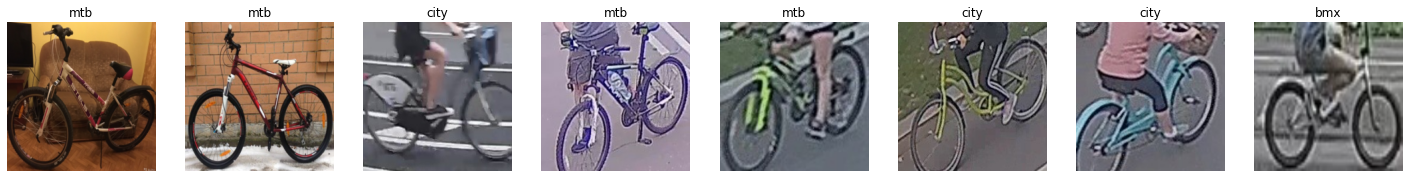

In [6]:
basic_train_dataset = datasets.ImageFolder('/content/bike/bike_type/train/', 
                                     transform=basic_transform)
print(len(basic_train_dataset))
train_loader = torch.utils.data.DataLoader(basic_train_dataset, 
                                           batch_size=8, 
                                           shuffle=True)
for images, class_nums in train_loader:
  for i, image in enumerate(images):
    tensor_show(image, basic_train_dataset.classes[class_nums[i]], i)
  break

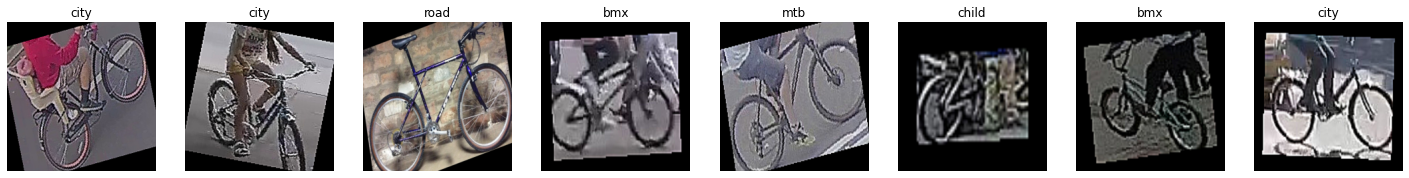

In [7]:
aug_train_dataset = datasets.ImageFolder('/content/bike/bike_type/train/', 
                                     transform=aug_transform)
train_loader = torch.utils.data.DataLoader(aug_train_dataset, 
                                           batch_size=8, 
                                           shuffle=True)
for images, class_nums in train_loader:
  for i, image in enumerate(images):
    tensor_show(image, aug_train_dataset.classes[class_nums[i]], i)
  break

In [8]:
train_dataset = torch.utils.data.ConcatDataset([basic_train_dataset, 
                                                torch.utils.data.Subset(
                                                    aug_train_dataset,
                                                    range(229))])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=8, 
                                           shuffle=True)

val_dataset = torch.utils.data.ConcatDataset(
    [datasets.ImageFolder('/content/bike/bike_type/val/', 
                          transform=basic_transform), 
     torch.utils.data.Subset(
         datasets.ImageFolder('/content/bike/bike_type/val/',
                              transform=aug_transform), 
         range(229))])
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=8,
                                         shuffle=True)

In [ ]:
def validate(model, testloader, device):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  return correct / total  

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 5)

device = torch.device("cuda")

model.train()
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)
best_accuracy = 0

for epoch in range(30):
  for img_batch, labels_batch in train_loader:
    optimizer.zero_grad()
    output = model(img_batch.to(device))
    loss = criterion(output, labels_batch.to(device))
    loss.backward()
    optimizer.step()
    images = img_batch.cpu()
    label_nums = output.cpu()
  accuracy = validate(model, val_loader, device)
  if best_accuracy < accuracy:
    best_accuracy = accuracy
  print("Epoch {} Loss {:.2f} Accuracy {:.2f}".format(
      epoch, loss.item(), accuracy))
print("Best accuracy {:.2f}".format(best_accuracy))

RuntimeError: ignored

#Отчёт

Создаём метод tensor_show для отображения батча считанного набора данных (взят из описанного показанного на семинаре блокнота).

Создаём 2 переменные basic_transform и aug_transform, где первая применяется для преобразования содержимого файлов к тензорам, а вторая - для аугментации данных. В качестве методов аугментации используем padding, поворот в пределах 15 градусов и SHARPEN (делает контуры более чёткими).

Считываем из файлов данные (как в исходном виде, так и с аугментациями) и объединяем в одну переменную train_dataset. Аналогично поступаем с данными для валидации.

Используем предобученную модель resnet18 и обучаем последний слой, замораживая все остальные (за счёт передачи параметров последнего слоя в оптимизатор). Обучаем модель с помощью кода из ДЗ 5.

В качестве Loss-функции используем CrossEntropyLoss для учитывания несбалансированности набора данных.

Точность получилось слегка лучше, чем в ДЗ 5.